# Building Models with Multiple Inputs

We know that there is a home court advantage in all sports, so we'll add a third input to capture this effect.

This model will have three inputs: `team_id_1`, `team_id_2`, and `home`. The team IDs will be integers that we look up in our team strength models, and `home` will be a binary variable, `1` if `team_1` is playing at home, `0` if they are not.

We'll re-use the `team_strength_model` from the previous exercise, notebook 4. After applying it to each input, use a `Concatenate` layer to join the two team strengths and with the home vs away variable, and pass the result to a `Dense` layer.

In [1]:
import pandas as pd
import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten, Subtract, Add, Concatenate
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
# load the data
full = pd.read_csv('./data/basket-ball/games_season.csv')
tournament = pd.read_csv('./data/basket-ball/games_tourney.csv')
full.shape, tournament.shape

((312178, 8), (4234, 9))

In [4]:
# Build the team strength Layer, Notebook 4
n_teams = unique(full['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(
    input_dim=n_teams,
    output_dim=1,
    input_length=1,
    name='Team-Strength'
)

teamid_in = Input(shape=(1,)) # input tensor
strength_lookup = team_lookup(teamid_in)
strength_lookup_flat = Flatten()(strength_lookup) # flattened output tensor

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

In [5]:
## Create three input layers
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

We can now wrap up out layers in a Keras model class, and then compile the model, so we can fit it to data and use it to make predictions on new data.

In [6]:
# Create a model using team_in_1, team_in_2, and home_in as inputs and out as the output.
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model using the 'adam' optimizer and 'mean_absolute_error' as the loss function
model.compile(optimizer='adam', loss='mean_absolute_error')

Our 3-input model is ready to be trained.

In [7]:
# Fit the model to the games_season dataset, using 'team_1', 'team_2' and 'home' columns 
# as inputs, and the 'score_diff' column as the target, using 1 epoch, 10% 
# validation split and a batch size of 2048.
model.fit([full['team_1'], full['team_2'], full['home']],
          full['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

print('\ntest set:')
# Evaluate the model on the testb dataset
model.evaluate(
    [tournament['team_1'], tournament['team_2'], tournament['home']],
    tournament['score_diff']
)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 1s 4us/step - loss: 12.0807 - val_loss: 12.0964

test set:
4234/4234 [==============================] - 0s 43us/step


11.680767018782625

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            (None, 1)            0                                            
__________

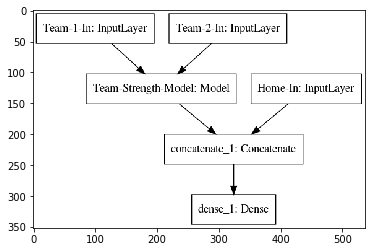

In [9]:
# Plot the model
plot_model(model, to_file='./img/model.png')

# Display the image
data = plt.imread('./img/model.png')
plt.imshow(data)
plt.show()

The model has:

* `10892` trainable parameters, 

* `3` input layers (only ever have out-going arrows), 

* `1` output layer (only ever have in-going arrows), and

* `1` shared layer, `Team-Strength-Model`.